<a href="https://colab.research.google.com/github/Datamin-D/Projects/blob/main/%5B%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A7%88%EC%9D%B4%EB%8B%9Dproject%5D_Instacart_reorder_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instacart Reorder Prediction

In [ ]:
# 방학 때 꼭 다시한다. 반나절이면 함.
# 성능 향상시키고프면 12 cart order 제대로 안되었으니 다시 봐봐 
# 1. 돌려서 1~12.
# 2. 벤치마크에서 addtocart 컬럼 살리면서 쭉쭉
# 3. 벤치마킹> 12번 제대로 되었나 확인, 피클 담으며 XG Boost실행.

In [ ]:
#libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# connecting colab
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# load data
order_products_train_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/order_products__train.csv")
order_products_prior_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/order_products__prior.csv")
orders_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/orders.csv")
products_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/products.csv")
aisles_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/aisles.csv")
departments_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/departments.csv")

In [ ]:
# orders_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/orders.csv")
# orders_df

# prior, train product 붙이기
order_products_all = pd.concat([order_products_train_df, order_products_prior_df], axis=0) #밑으로 붙이기.

In [ ]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


# 1.EDA

## 0) order product에대한 결측치 확인(id,addtocart도) 

In [ ]:
order_products_all = pd.concat([order_products_train_df, order_products_prior_df], axis=0) #밑으로 붙이기.
missing_value = order_products_all.isnull().sum().sort_values(ascending=False)
missing_value

#결측치 전무.

reordered            0
add_to_cart_order    0
product_id           0
order_id             0
dtype: int64

In [ ]:
order_products_all

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


orders_df 를 기준으로 EDA 실행.

컬럼 별로 순서대로 분석진행.

물론 train data로 모델을 학습시키고 test를 predict하는것이 목적이지만

300만개 가량의 prior 주문까지 EDA 함으로서 전체적인 경향을 파악하는데 용이할 것이라 판단했다.  

## 1) number of cutomers

In [ ]:
def unique_count(x):
    return len(np.unique(x))

count_distinct_customer = orders_df.groupby("eval_set")["user_id"].agg(unique_count) #agg로 사용자 정의함수 쓰기 가능
count_distinct_customer

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

In [ ]:
# eval set별로 분류한 order
orders_df["eval_set"].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

eval_set중 prior을 제외하고는 모두 distinct customer.

## 2) 유저 별 max주문량 

min 주문량은 의미 없음. 이 데이터에 들어온 이상 이미 min 주문량은 1이기떄문.

In [ ]:
  orders_df.groupby("user_id")["order_number"].agg(np.max).reset_index() #df.groupby('묶을 컬럼')[값을 보여줄 칼럼].메서드()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


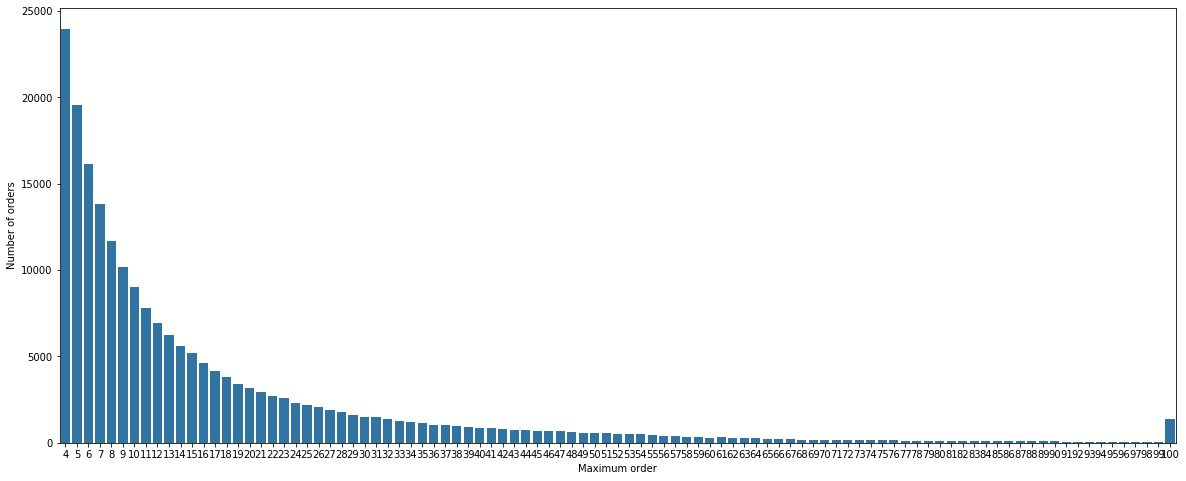

In [ ]:
count_max = orders_df.groupby("user_id")["order_number"].agg(np.max).reset_index() #reset_index로 index로 쓰이던 컬럼 빼낼 수도 있음!
count_max = count_max.order_number.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(count_max.index, count_max.values, color=color[0]) #color 통일하고 싶을때는 color = color[인덱스] 넣어주기
plt.ylabel('Number of orders', fontsize=10)
plt.xlabel('Maximum order', fontsize=10)

plt.show()

위 그래프에서 볼 수 있듯, 소비자들은 4개 미만으로 주문한 적은 없음.

또한 100을 넘어가는 주문도 존재하지 않음

## 3) prior order, train order, test order 추이

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


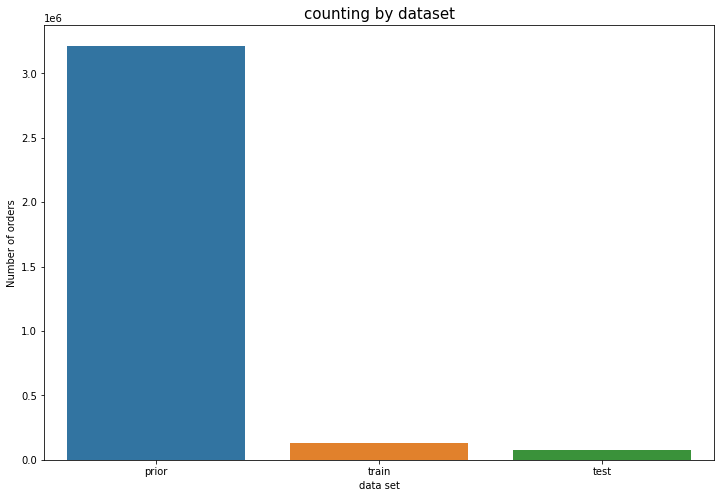

In [ ]:
data_set_count = orders_df["eval_set"].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(data_set_count.index, data_set_count.values) #sns.barplot(x축값, y축값, alpha = transparency(투명도),color = color[0,1,--])
plt.ylabel('Number of orders', fontsize=10)
plt.xlabel('data set', fontsize=10)
plt.title('counting by dataset', fontsize=15)
plt.show()

In [ ]:
orders_df["eval_set"].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

## 4) 주문 시간대 파악

### 4-1) day of week

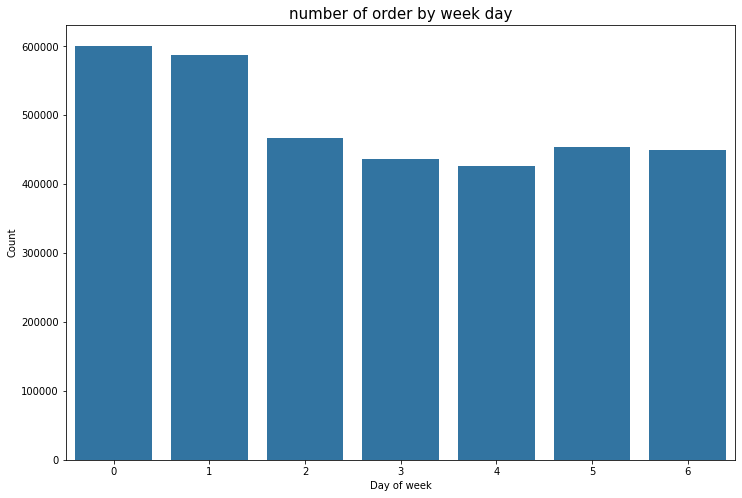

In [ ]:
# Date column
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=10)
plt.xlabel('Day of week', fontsize=10)

plt.title("number of order by week day", fontsize=15)
plt.show()

#--> 0,1 즉, 주말인지 or 평일인지에 따라 구분하는 것이 좋겠다.

### --> holidays/weekdays 구분하는 컬럼 추가

In [ ]:
# holyday/weekday 구분 weekday = 1 평일 = 0 주말 
def amiweekday(x):
  if (x == 1) or (x == 0 ):
    weekday = 0
  else:
    weekday = 1
  return weekday 

# True or False # 하면 True나옴.


orders_df["weekday"]= orders_df["order_dow"].apply(amiweekday)
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday
0,2539329,1,prior,1,2,8,NaN,1
1,2398795,1,prior,2,3,7,15.0,1
2,473747,1,prior,3,3,12,21.0,1
3,2254736,1,prior,4,4,7,29.0,1
4,431534,1,prior,5,4,15,28.0,1
...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,1
3421079,1854736,206209,prior,11,4,10,30.0,1
3421080,626363,206209,prior,12,1,12,18.0,0
3421081,2977660,206209,prior,13,1,12,7.0,0


### 4-2) hour of day

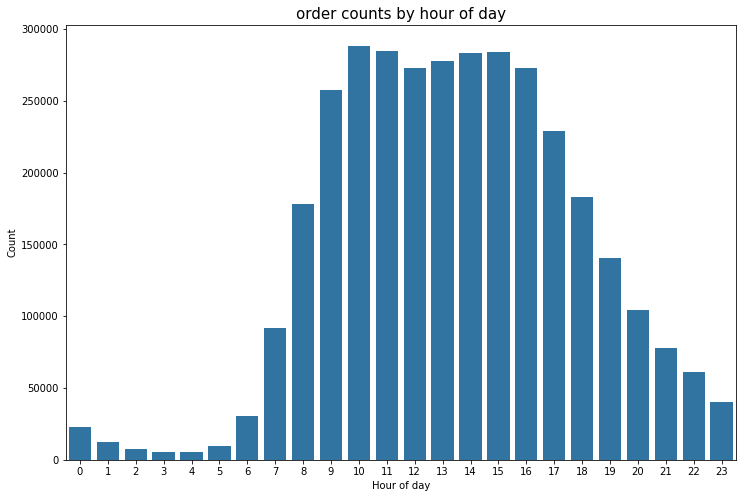

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=10)
plt.xlabel('Hour of day', fontsize=10)

plt.title("order counts by hour of day", fontsize=15)
plt.show()

주문은 오전9시부터 오후5시까지가 피크. 그 전후로 서서히 줄어든다

day of week와 달리 hour of day는 7,8시, 19시,20시에서 보듯 서서히 줄어드는 경향을 가짐. 

따라서 시간에 따른 count 값을 학습에 넣어보면 어떨까? 

아니면 아예 뺴보는 시도도 좋을듯,,

### --> 주문시간에 따른 count 값 넣기(제거 고려)

In [ ]:
hour_count = orders_df['order_hour_of_day'].value_counts().reset_index()
hour_count.columns = ['order_hour_of_day','order_count_time']
time_sum = hour_count['order_count_time'].sum()
hour_count['order_count_time'] = hour_count['order_count_time'].map(lambda x: x/time_sum)
hour_count

#hour_count.rename(columns = {"index": "ID_2"}, inplace = True)

# 한 테이블 참조해서 값 다른 테이블에 붙여넣기
orders_df = pd.merge(orders_df,hour_count,how = 'left',on = 'order_hour_of_day') #https://rfriend.tistory.com/258

orders_df[orders_df.order_hour_of_day.isnull()] # 결측치 없이 잘 연결됨.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time


## 5) days_since_prior_order

말이 days_since_prior_order이지 사실 재주문까지 걸린 days를 나타낸다.

중요한 포인트 잡아낼 수 있을듯,,


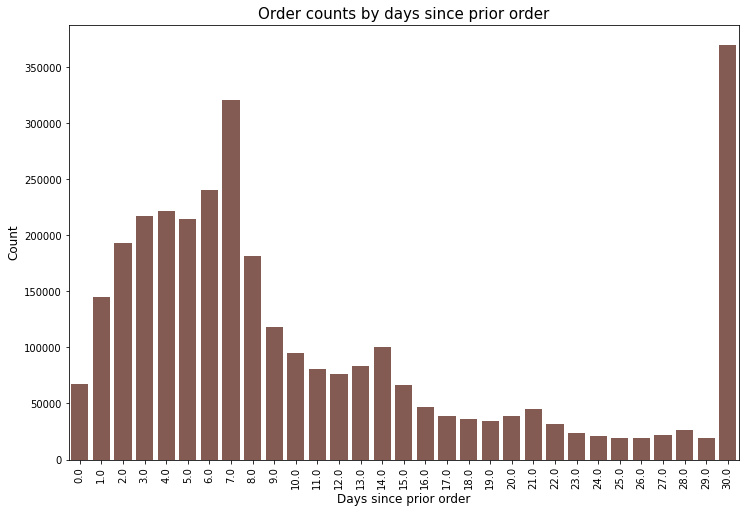

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[5]) # sns.countplot(x = '사용할 컬럼',data = df, color = color[내맘대로 인덱스])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Order counts by days since prior order", fontsize=15)
plt.show()

압도적으로 30일만에 주문이 많음. 혹시 30일 이후는 전부 30으로친게 아닌지?

어쨌든 주문한지 30일/일주일 안팎에 재주문 할 확률이 크다는것..

주의. 주문한지 일주일을 1~8일로 두자.

### --> 주문한지 일주일이 되었는지(1~8일) 30일 또는 이상인지 컬럼 추가 

In [ ]:
#결측치 다수 발견
orders_df[orders_df['days_since_prior_order'].isnull()] #eval_set이 prior_order인 경우에 해당.. 신경쓸필요 없음. 어차피 train만으로 훈련.


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time
0,2539329,1,prior,1,2,8,NaN,1,0.052089
11,2168274,2,prior,1,2,11,NaN,1,0.083227
26,1374495,3,prior,1,1,14,NaN,0,0.082735
39,3343014,4,prior,1,6,11,NaN,1,0.083227
45,2717275,5,prior,1,3,12,NaN,1,0.079753
...,...,...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN,1,0.079753
3420934,3189322,206206,prior,1,3,18,NaN,1,0.053466
3421002,2166133,206207,prior,1,6,19,NaN,1,0.041089
3421019,2227043,206208,prior,1,1,15,NaN,0,0.082909


In [ ]:
# 주문한지 일주일이 되었는지,

def reorder_in_a_week(x):
  if 0 < x < 9:
    val = 1
  else:
    val = 0
  return val

orders_df['reorder_in_a_week'] = orders_df['days_since_prior_order'].apply(lambda x: reorder_in_a_week(x))
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week
0,2539329,1,prior,1,2,8,NaN,1,0.052089,0
1,2398795,1,prior,2,3,7,15.0,1,0.026853,0
2,473747,1,prior,3,3,12,21.0,1,0.079753,0
3,2254736,1,prior,4,4,7,29.0,1,0.026853,0
4,431534,1,prior,5,4,15,28.0,1,0.082909,0
...,...,...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,1,0.053466,0
3421079,1854736,206209,prior,11,4,10,30.0,1,0.084306,0
3421080,626363,206209,prior,12,1,12,18.0,0,0.079753,0
3421081,2977660,206209,prior,13,1,12,7.0,0,0.079753,1


In [ ]:
#주문한지 1달 또는 이상
def reorder_in_a_month(x):
  if x == 30:
    val = 1
  else:
    val = 0
  return val

orders_df['reorder_in_a_month'] = orders_df['days_since_prior_order'].apply(lambda x: reorder_in_a_month(x))
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month
0,2539329,1,prior,1,2,8,NaN,1,0.052089,0,0
1,2398795,1,prior,2,3,7,15.0,1,0.026853,0,0
2,473747,1,prior,3,3,12,21.0,1,0.079753,0,0
3,2254736,1,prior,4,4,7,29.0,1,0.026853,0,0
4,431534,1,prior,5,4,15,28.0,1,0.082909,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,1,0.053466,0,0
3421079,1854736,206209,prior,11,4,10,30.0,1,0.084306,0,1
3421080,626363,206209,prior,12,1,12,18.0,0,0.079753,0,0
3421081,2977660,206209,prior,13,1,12,7.0,0,0.079753,1,0


# ------------ 위엔 orders_df 밑엔 order_products_all---------------

## 6) 가장 많이 주문한 물품


In [ ]:
frequently_ordered = order_products_all['product_id'].value_counts().reset_index()
frequently_ordered.columns = ['product_id','order_count_product']
frequently_ordered


,product_id,order_count_product
0,24852,491291
1,13176,394930
2,21137,275577
3,21903,251705
4,47209,220877
...,...,...
49680,42235,1
49681,5255,1
49682,44495,1
49683,36079,1


In [ ]:
# 제품명 보기위해 merge
order_products = pd.merge(frequently_ordered, products_df, on='product_id', how='left')

product_count = order_products[['product_name', 'order_count_product']]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


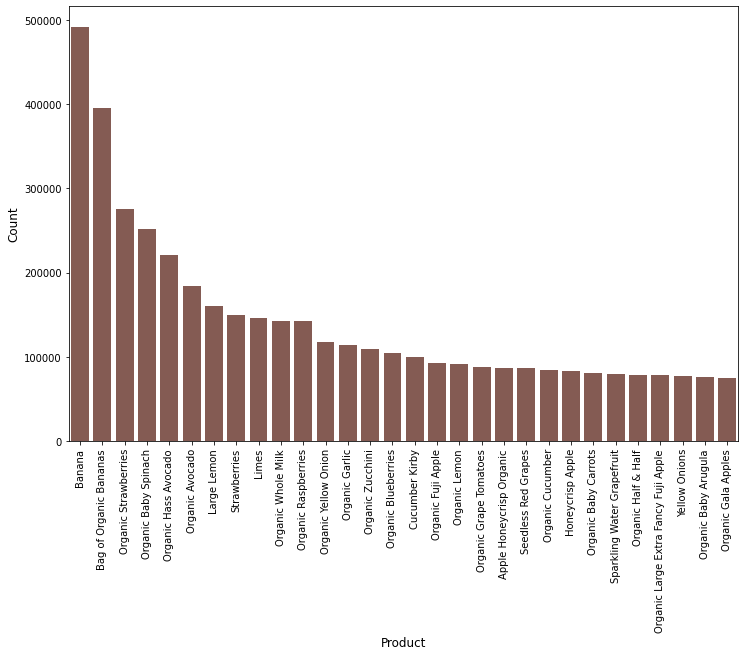

In [ ]:
product_count_for_graph = product_count.head(30) #상위 30개만
plt.figure(figsize=(12,8))
sns.barplot(product_count_for_graph['product_name'].values, product_count_for_graph['order_count_product'].values, color=color[5])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

###--> 상품별 구매 비율

In [ ]:
order_product_count_sum = frequently_ordered['order_count_product'].sum()
frequently_ordered['order_count_product'] = frequently_ordered['order_count_product'].map(lambda x: x/order_product_count_sum)
frequently_ordered
order_products_all = pd.merge(order_products_all,frequently_ordered,how = 'left',on = 'product_id')

상위 30개의 품목. 야채,과일, organic food가 주류를 이룬다.

In [ ]:
# #나중에 합치기위해 분리
# order_count_product = order_products_all[['product_id','order_count_product']]
# order_count_product

## 7) 가장 많이 주문이 일어난 department 

In [ ]:
order_products_all = pd.merge(order_products_all, products_df, on='product_id', how='left')
order_products_all = pd.merge(order_products_all, departments_df, on='department_id', how='left')
order_products_all


,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods
...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce


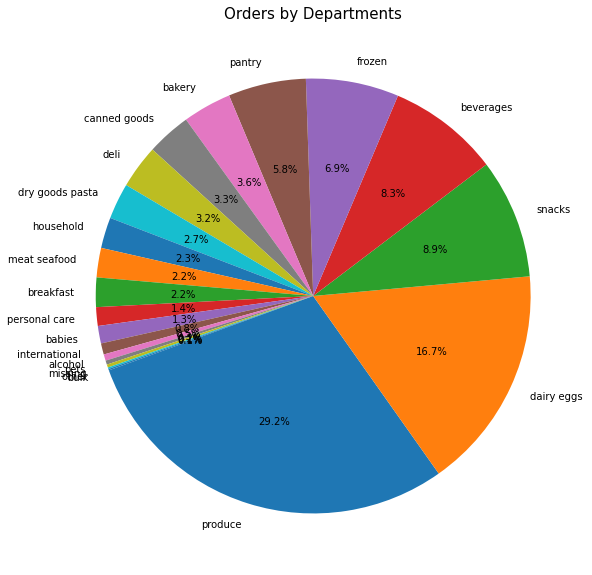

In [ ]:
plt.figure(figsize=(10,10))
dept_count = order_products_all['department'].value_counts()
labels = (np.array(dept_count.index))
sizes = (np.array((dept_count / dept_count.sum())*100)) # 전체를 나눠줘야 파이로 100%나타냄.
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Orders by Departments", fontsize=15)
plt.show()

produce가 압도적. 하지만 어디서 잘라야할지 모르겠다... 숫자로 넣을까

In [ ]:
dept_count = order_products_all['department'].value_counts()
dept_count = dept_count.reset_index()
dept_count.columns = ['department','order_count_dept']
dept_count

,department,order_count_dept
0,produce,9888378
1,dairy eggs,5631067
2,snacks,3006412
3,beverages,2804175
4,frozen,2336858
5,pantry,1956819
6,bakery,1225181
7,canned goods,1114857
8,deli,1095540
9,dry goods pasta,905340


In [ ]:
order_dept_count_sum = dept_count['order_count_dept'].sum()
order_dept_count_sum

dept_count['order_count_dept'] = dept_count['order_count_dept'].map(lambda x: x/order_dept_count_sum)


In [ ]:
#order_count_dept 컬럼으로 넣어주기. 
order_products_all = pd.merge(order_products_all,dept_count,how = 'left',on = 'department')
#order_products_all = pd.order_count_dept

In [ ]:
# #order_count_dept 떼어내기 -->abort
# order_count_dept = order_products_all[['product_id','order_count_dept']]
# order_count_dept



## 8) 가장 많은 주문이 일어난 aisle

In [ ]:
order_products_all = pd.merge(order_products_all, aisles_df, on='aisle_id', how='left')
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood
...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


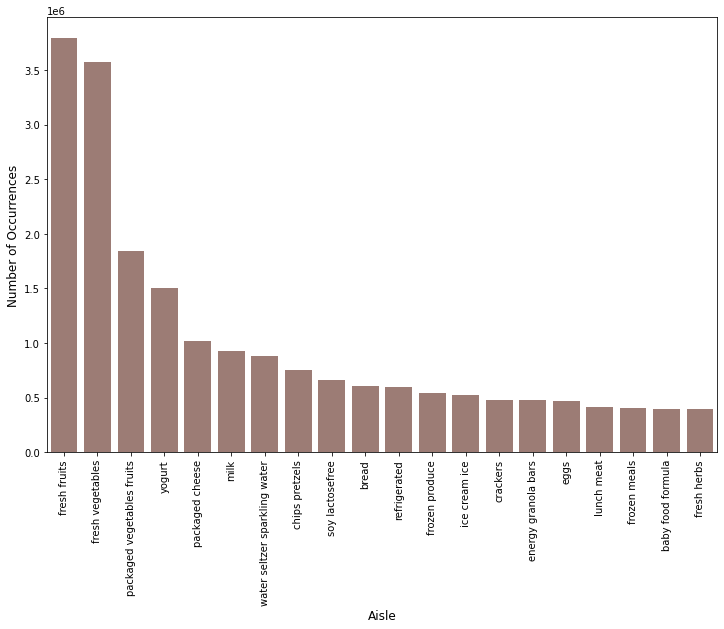

In [ ]:
cnt_srs = order_products_all['aisle'].value_counts().head(20) # 상위 20개만
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
order_count_aisle = order_products_all['aisle'].value_counts().reset_index()
order_count_aisle.columns = ['aisle','order_count_aisle']
order_count_aisle_sum = order_count_aisle.order_count_aisle.sum()
order_count_aisle['order_count_aisle'] = order_count_aisle['order_count_aisle'].map(lambda x: x/order_count_aisle_sum)
order_count_aisle

,aisle,order_count_aisle
0,fresh fruits,0.112146
1,fresh vegetables,0.105521
2,packaged vegetables fruits,0.054520
3,yogurt,0.044578
4,packaged cheese,0.030204
...,...,...
129,eye ear care,0.000282
130,baby bath body care,0.000263
131,baby accessories,0.000250
132,beauty,0.000191


In [ ]:
order_products_all = pd.merge(order_products_all,order_count_aisle,how = 'left',on = 'aisle')
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt,0.044578
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables,0.105521
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables,0.105521
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood,0.002078
...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents,0.002921
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers,0.014147
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast,0.007170
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits,0.112146


vege많이 시킴. 이 컬럼 또한 count값 넣어주기. 

개선점: 6,7,8의 경우 절대적인 count 값을 기준으로 df만듦. 이러지말고 (한prod나 aisle 등의 count)/(총 count 중에 비율로 넣어도 ㄱㅊ할듯)

## 9) 물품 별 reorder ratio



In [ ]:
grouped_df = order_products_all.groupby(["product_name"])["reordered"].aggregate("mean").reset_index()
product_reorder_ratio = grouped_df.sort_values(by = ['reordered'],ascending= False)
product_reorder_ratio.columns = ['product_name',	'product_reordered_ratio']


In [ ]:
product_reorder_ratio

,product_name,product_reordered_ratio
37379,Raw Veggie Wrappers,0.942029
39870,Serenity Ultimate Extrema Overnight Pads,0.933333
28415,Orange Energy Shots,0.923077
8537,Chocolate Love Bar,0.921569
41723,Soy Powder Infant Formula,0.914286
...,...,...
43661,Superfruit Pomegranate Green Tea,0.000000
33719,Paleo Magazine,0.000000
43652,"Superfood Smoothie, Organic, Energy, Mocha Java",0.000000
8246,Chocolate Almond Bar,0.000000


In [ ]:
order_products_all = pd.merge(order_products_all,product_reorder_ratio,on = 'product_name', how = 'left') 

In [ ]:
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt,0.044578,0.631579
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables,0.105521,0.525032
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables,0.105521,0.692103
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood,0.002078,0.475628
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents,0.002921,0.438596
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers,0.014147,0.691140
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast,0.007170,0.644371
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits,0.112146,0.845051


## 10) department 별 reorder ratio 

In [ ]:
dept_reorder_ratio = order_products_all.groupby(["department"])["reordered"].aggregate("mean").reset_index()
dept_reorder_ratio.columns = ['department',	'dept_reorder_ratio']

In [ ]:
dept_reorder_ratio

,department,dept_reorder_ratio
0,alcohol,0.571221
1,babies,0.577680
2,bakery,0.628381
3,beverages,0.653651
4,breakfast,0.561351
5,bulk,0.577090
6,canned goods,0.458639
7,dairy eggs,0.670161
8,deli,0.608130
9,dry goods pasta,0.462220


In [ ]:
order_products_all = pd.merge(order_products_all,dept_reorder_ratio,on = 'department', how = 'left') 

## 11) aisle 별 reorder ratio

In [ ]:
aisle_reorder_ratio = order_products_all.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()
aisle_reorder_ratio.columns = ['department_id','aisle','aisle_reorder_ratio']
aisle_reorder_ratio = aisle_reorder_ratio[['aisle','aisle_reorder_ratio']]
#aisle_reorder_ratio

In [ ]:
aisle_reorder_ratio.sort_values(by = 'aisle_reorder_ratio', ascending=False)

,aisle,aisle_reorder_ratio
96,milk,0.781812
38,water seltzer sparkling water,0.729930
17,fresh fruits,0.718823
95,eggs,0.706359
100,soy lactosefree,0.692361
...,...,...
48,beauty,0.212858
56,first aid,0.195864
107,kitchen supplies,0.194802
73,baking supplies decor,0.167595


In [ ]:
order_products_all = pd.merge(order_products_all,aisle_reorder_ratio,how = 'left',on = 'aisle')
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt,0.044578,0.631579,0.670161,0.686501
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161,0.565850
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables,0.105521,0.525032,0.650521,0.595057
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables,0.105521,0.692103,0.650521,0.595057
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood,0.002078,0.475628,0.458639,0.478865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents,0.002921,0.438596,0.403339,0.393777
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers,0.014147,0.691140,0.574464,0.569874
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast,0.007170,0.644371,0.542634,0.627179
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits,0.112146,0.845051,0.650521,0.718823


## 12) Cart-reorder

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


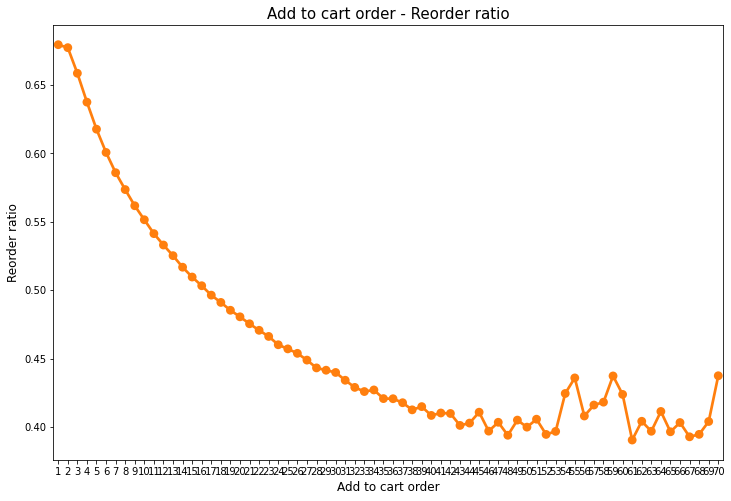

In [ ]:
order_products_all["add_to_cart_order_mod"] = order_products_all["add_to_cart_order"].copy()
order_products_all["add_to_cart_order_mod"].iloc[order_products_all["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_all.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)

plt.show()

In [ ]:
grouped_df.columns = ['add_to_cart_order',	'cart_reordered_ratio']
order_products_all = pd.merge(order_products_all,grouped_df,how = 'left',on = 'add_to_cart_order')
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio,add_to_cart_order_mod,cart_reordered_ratio
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt,0.044578,0.631579,0.670161,0.686501,1,0.679302
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161,0.565850,2,0.677135
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables,0.105521,0.525032,0.650521,0.595057,3,0.658426
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables,0.105521,0.692103,0.650521,0.595057,4,0.637350
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood,0.002078,0.475628,0.458639,0.478865,5,0.617598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents,0.002921,0.438596,0.403339,0.393777,6,0.600603
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers,0.014147,0.691140,0.574464,0.569874,7,0.585810
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast,0.007170,0.644371,0.542634,0.627179,8,0.573495
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits,0.112146,0.845051,0.650521,0.718823,9,0.561681


add to cart에 늦게담은 상품일수록 reorder ratio가 낮게 나타남. 이를 파악할 수 있도록 만듦.

## 13) orders_df, order_products_all 합치기_csv로 만들기

In [ ]:
# order_products_all.to_csv('/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/order_products_all.csv')
# orders_df.to_csv('/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/orders_df')

KeyboardInterrupt: ignored

In [ ]:
order_products_all

# 2.Train,Test data 준비

In [ ]:
order_products_all = pd.read_csv('/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/order_products_all.csv')
orders_df = pd.read_csv('/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/orders_df')
order_products_all

KeyboardInterrupt: ignored

In [ ]:
#order_id로 합쳐
orders = pd.merge(order_products_all,orders_df,how = 'inner', on = 'order_id')

#필요없는 컬럼 버리기
orders = orders.drop(['Unnamed: 0_x','product_id',	'add_to_cart_order','product_name','aisle_id',	'department_id',	'department','aisle','Unnamed: 0_y','user_id',	'eval_set','order_number','order_dow',	'order_hour_of_day',	'days_since_prior_order','order_id','add_to_cart_order_mod'],axis = 1)
orders

In [ ]:
orders

In [ ]:
# training set만 추리기
train_df = orders[orders['eval_set'] == 'train']

# train 
train_df



In [ ]:
#test data 추리기

 = pd.read_csv('/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/sample_submission.csv', usecols=["order_id"])


0           False
1           False
2           False
3           False
4           False
            ...  
33819101    False
33819102    False
33819103    False
33819104    False
33819105    False
Name: eval_set, Length: 33819106, dtype: bool

In [ ]:
test = orders[orders['eval_set'] == 'test']
test

,Unnamed: 0_x,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio,add_to_cart_order_mod,cart_reordered_ratio,Unnamed: 0_y,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month
10,1187899,1,train,11,4,8,14.0,1,0.052089,0,0
25,1492625,2,train,15,1,11,30.0,0,0.083227,0,1
49,2196797,5,train,5,0,11,6.0,0,0.083227,1,0
74,525192,7,train,21,2,11,6.0,1,0.083227,1,0
78,880375,8,train,4,1,14,10.0,0,0.082735,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3420838,2585586,206199,train,20,2,16,30.0,1,0.079669,0,1
3420862,943915,206200,train,24,6,19,6.0,1,0.041089,1,0
3420924,2371631,206203,train,6,4,19,30.0,1,0.041089,0,1
3420933,1716008,206205,train,4,1,16,10.0,0,0.079669,0,0


In [ ]:
order_products_all

,order_id,product_id,add_to_cart_order,reordered,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio,add_to_cart_order_mod,cart_reordered_ratio
0,1,49302,1,1,0.000005,Bulgarian Yogurt,120,16,dairy eggs,0.166505,yogurt,0.044578,0.631579,0.670161,0.686501,1,0.679302
1,1,11109,2,1,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161,0.565850,2,0.677135
2,1,10246,3,0,0.000736,Organic Celery Hearts,83,4,produce,0.292390,fresh vegetables,0.105521,0.525032,0.650521,0.595057,3,0.658426
3,1,49683,4,0,0.002949,Cucumber Kirby,83,4,produce,0.292390,fresh vegetables,0.105521,0.692103,0.650521,0.595057,4,0.637350
4,1,43633,5,1,0.000020,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,0.032965,canned meat seafood,0.002078,0.475628,0.458639,0.478865,5,0.617598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,1,0.000054,Free & Clear Natural Dishwasher Detergent,74,17,household,0.022906,dish detergents,0.002921,0.438596,0.403339,0.393777,6,0.600603
33819102,3421083,11352,7,0,0.000216,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,0.088897,crackers,0.014147,0.691140,0.574464,0.569874,7,0.585810
33819103,3421083,4600,8,0,0.000081,All Natural French Toast Sticks,52,1,frozen,0.069099,frozen breakfast,0.007170,0.644371,0.542634,0.627179,8,0.573495
33819104,3421083,24852,9,1,0.014527,Banana,24,4,produce,0.292390,fresh fruits,0.112146,0.845051,0.650521,0.718823,9,0.561681


In [ ]:
orders_test = orders_df[orders_df['eval_set'] == 'test']
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month
38,2774568,3,test,13,5,15,11.0,1,0.082909,0,0
44,329954,4,test,6,3,12,30.0,1,0.079753,0,1
53,1528013,6,test,4,3,16,22.0,1,0.079669,0,0
96,1376945,11,test,8,6,11,8.0,1,0.083227,1,0
102,1356845,12,test,6,1,20,30.0,0,0.030485,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0,1,0.066878,1,0
3420929,350108,206204,test,5,4,14,14.0,1,0.082735,0,0
3421001,1043943,206206,test,68,0,20,0.0,0,0.030485,0,0
3421018,2821651,206207,test,17,2,13,14.0,1,0.081261,0,0


In [ ]:
##order_id 로 합치면 되겠다! 

In [ ]:
#필요없는 컬럼 없애기


# Training

In [ ]:
### Import necessary modules ###
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics, model_selection

In [ ]:
# load data
order_products_train_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/order_products__train.csv")
order_products_prior_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/order_products__prior.csv")
orders_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/orders.csv")
products_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/products.csv")
aisles_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/aisles.csv")
departments_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/departments.csv")

In [ ]:
orders_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/orders.csv",usecols=["order_id","user_id","order_number"])
orders_df

,order_id,user_id,order_number
0,2539329,1,1
1,2398795,1,2
2,473747,1,3
3,2254736,1,4
4,431534,1,5
...,...,...,...
3421078,2266710,206209,10
3421079,1854736,206209,11
3421080,626363,206209,12
3421081,2977660,206209,13


In [ ]:
prior_df = pd.read_csv("/gdrive/My Drive/석사 수업/데이터마이닝/Instacart/order_products__prior.csv")
prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [ ]:
# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3
...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,24
32434485,3421083,11352,7,0,25247,24
32434486,3421083,4600,8,0,25247,24
32434487,3421083,24852,9,1,25247,24


In [ ]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()

prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]



In [ ]:
prior_df_latest

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0
...,...,...,...
2139783,79937,23400,0
2139784,79937,39812,0
2139785,79937,15795,0
2139786,103510,49187,0


In [ ]:
# merge with the orders file to get the user_id #
#prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")

# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]

# get the count of each product and number of reorders by the customer #
prior_df = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df
prior_df.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]


prior_df

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2
...,...,...,...,...
13307948,206209,43961,3,2
13307949,206209,44325,1,0
13307950,206209,48370,1,0
13307951,206209,48697,1,0


In [ ]:
# merge the prior df with latest df #
prior_df = pd.merge(prior_df, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df.head()

In [ ]:
orders_df.drop(["order_number"],axis=1,inplace=True)

In [ ]:
orders_df

In [ ]:
#orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/order_products__train.csv", usecols=["order_id"])
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df
test_df = pd.read_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/sample_submission.csv", usecols=["order_id"])
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
print(train_df.shape, test_df.shape)
train_df


In [ ]:
train_df = pd.merge(train_df, prior_df, how="inner", on="user_id")
test_df = pd.merge(test_df, prior_df, how="inner", on="user_id")
del prior_df, prior_grouped_df, prior_df_latest
print(train_df.shape, test_df.shape)
train_df

In [ ]:
## 컬럼값 추가
train_df.to_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df_pre_merge.csv")

In [ ]:
frequently_ordered = pd.merge(frequently_ordered,products_df,on = 'product_id',how = 'left')
frequently_ordered

In [ ]:
frequently_ordered = pd.merge(frequently_ordered,departments_df,how = 'left' ,on = 'department_id')
frequently_ordered

In [ ]:
# 6) order_count_product 뻑남 -->우회하여 성공
# train_df = pd.merge(train_df,order_count_product,how = 'inner',on = 'product_id')
# train_df
#우회. 
train_df = pd.merge(train_df,frequently_ordered,on = 'product_id',how = 'left')
train_df #성공
#train_df[train_df['order_count_product'].isnull()]# 널값없이 잘 합쳐짐

In [ ]:
# 6) order_count_product test
test_df = pd.merge(test_df,frequently_ordered,on = 'product_id',how = 'left')
test_df #성공

In [ ]:
#7) dept 추가 -->뻑남
# train_df = pd.merge(train_df,order_count_dept,how = 'left',on = 'product_id')
# train_df

#우회

train_df =  pd.merge(train_df, dept_count, on ='department', how = 'left')
train_df

In [ ]:
#7 test
test_df =  pd.merge(test_df, dept_count, on ='department', how = 'left')
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897
...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973


In [ ]:
order_count_aisle = pd.merge(order_count_aisle,aisles_df,how = 'left',on = 'aisle')
order_count_aisle

,aisle,order_count_aisle,aisle_id
0,fresh fruits,0.112146,24
1,fresh vegetables,0.105521,83
2,packaged vegetables fruits,0.054520,123
3,yogurt,0.044578,120
4,packaged cheese,0.030204,21
...,...,...,...
129,eye ear care,0.000282,44
130,baby bath body care,0.000263,102
131,baby accessories,0.000250,82
132,beauty,0.000191,132


In [ ]:
#8)aisle 추가
train_df = pd.merge(train_df,order_count_aisle,how = 'left',on = 'aisle_id')
train_df


In [ ]:
#8)aisle 추가 test
test_df = pd.merge(test_df,order_count_aisle,how = 'left',on = 'aisle_id')
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699


In [ ]:
# 까지한 내용 피클로 저장
import pickle

with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df10.pickle","wb") as fw:
  pickle.dump(train_df,fw)


In [ ]:
#test_df 피클로 저장.

import pickle

with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/test_df8.pickle","wb") as fw:
  pickle.dump(test_df,fw)


In [ ]:
#train피클꺼내기  8까지함
import pickle
with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df10.pickle","rb") as fr:
    train_df = pickle.load(fr)
train_df

In [ ]:
# test피클 꺼내기
import pickle
with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df8.pickle","rb") as fr:
    test_df = pickle.load(fr)
test_df

In [ ]:
#9) product별 reorder ratio 추가

train_df = pd.merge(train_df,product_reorder_ratio,how = 'left',on = 'product_name')
train_df

In [ ]:
#9) product별 reorder ratio 추가 test

test_df = pd.merge(test_df,product_reorder_ratio,how = 'left',on = 'product_name')
test_df


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289,0.250000
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644,0.616715
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289,0.479490
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289,0.364542
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011,0.631043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341,0.296552
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520,0.467445
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546,0.414832
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699,0.467359


In [ ]:
#10) dept별 reorder ratio 추가

train_df = pd.merge(train_df,dept_reorder_ratio,how = 'left',on = 'department')
train_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio
0,1,112108,2067,1,0,NaN,0.000096,Plus Cranberry Almond + Antioxidants with Maca...,3,19,snacks,0.088897,energy granola bars,0.014011,0.604579,0.574464
1,1,112108,5707,2,1,1.0,0.000037,Dark Chocolate Cinnamon Pecan Bar,3,19,snacks,0.088897,energy granola bars,0.014011,0.573279,0.574464
2,1,112108,11109,2,1,NaN,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161
3,1,112108,14947,3,2,1.0,0.000887,Pure Sparkling Water,115,7,beverages,0.082917,water seltzer sparkling water,0.025966,0.813423,0.653651
4,1,112108,22035,2,1,NaN,0.001823,Organic Whole String Cheese,21,16,dairy eggs,0.166505,packaged cheese,0.030204,0.765441,0.670161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3421070,139822,31506,1,0,NaN,0.001547,Extra Virgin Olive Oil,19,13,pantry,0.057861,oils vinegars,0.007572,0.477496,0.347400
8474657,3421070,139822,34035,1,0,NaN,0.000002,Hamburger Bun,43,3,bakery,0.036227,buns rolls,0.003491,0.288462,0.628381
8474658,3421070,139822,35347,1,0,NaN,0.000017,French Roast Single Serve Coffee K-Cups,26,7,beverages,0.082917,coffee,0.006371,0.511036,0.653651
8474659,3421070,139822,35951,5,4,NaN,0.001776,Organic Unsweetened Almond Milk,91,16,dairy eggs,0.166505,soy lactosefree,0.019648,0.758403,0.670161


In [ ]:
#10) dept별 reorder ratio 추가 test

test_df = pd.merge(test_df,dept_reorder_ratio,how = 'left',on = 'department')
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289,0.250000,0.394323
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644,0.616715,0.561351
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289,0.479490,0.394323
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289,0.364542,0.394323
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011,0.631043,0.574464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341,0.296552,0.458639
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520,0.467445,0.650521
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546,0.414832,0.347400
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699,0.467359,0.577680


In [ ]:
#11) aisle별 reorder ratio 추가

train_df = pd.merge(train_df,aisle_reorder_ratio,how = 'left',on = 'aisle')
train_df

In [ ]:
#11) test
test_df = pd.merge(test_df,aisle_reorder_ratio,how = 'left',on = 'aisle')
test_df


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289,0.250000,0.394323,0.394323
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644,0.616715,0.561351,0.572233
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289,0.479490,0.394323,0.394323
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289,0.364542,0.394323,0.394323
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011,0.631043,0.574464,0.597995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341,0.296552,0.458639,0.506026
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520,0.467445,0.650521,0.639275
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546,0.414832,0.347400,0.152933
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699,0.467359,0.577680,0.589005


In [ ]:
#12) cart-order별로 값주기
train_df = pd.merge(train_df,grouped_df,on = 'add_to_cart_order',how = 'left')
train_df

In [ ]:
#12)
test_df = pd.merge(test_df,grouped_df,on = 'add_to_cart_order',how = 'left')
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio_x,aisle_reorder_ratio_y
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289,0.250000,0.394323,0.394323,0.394323
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644,0.616715,0.561351,0.572233,0.572233
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289,0.479490,0.394323,0.394323,0.394323
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289,0.364542,0.394323,0.394323,0.394323
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011,0.631043,0.574464,0.597995,0.597995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341,0.296552,0.458639,0.506026,0.506026
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520,0.467445,0.650521,0.639275,0.639275
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546,0.414832,0.347400,0.152933,0.152933
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699,0.467359,0.577680,0.589005,0.589005


In [ ]:
#최종 train_df 피클로 저장.
# 까지한 내용 피클로 저장


with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df12.pickle","wb") as fw:
  pickle.dump(train_df,fw)


In [ ]:
#test_df 피클로 저장.
# 까지한 내용 피클로 저장
import pickle

with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/test_df12.pickle","wb") as fw:
  pickle.dump(test_df,fw)


## Train_df,test_df 피클

In [ ]:
#addtoordercart 먼저추가 해보기


In [ ]:
#여기부터 돌리셈!
import pickle
#피클꺼내기  12까지함

with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/train_df12.pickle","rb") as fr:
    train_df = pickle.load(fr)
train_df



,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio_x,aisle_reorder_ratio_y
0,1,112108,2067,1,0,NaN,0.000096,Plus Cranberry Almond + Antioxidants with Maca...,3,19,snacks,0.088897,energy granola bars,0.014011,0.604579,0.574464,0.597995,0.597995
1,1,112108,5707,2,1,1.0,0.000037,Dark Chocolate Cinnamon Pecan Bar,3,19,snacks,0.088897,energy granola bars,0.014011,0.573279,0.574464,0.597995,0.597995
2,1,112108,11109,2,1,NaN,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161,0.565850,0.565850
3,1,112108,14947,3,2,1.0,0.000887,Pure Sparkling Water,115,7,beverages,0.082917,water seltzer sparkling water,0.025966,0.813423,0.653651,0.729930,0.729930
4,1,112108,22035,2,1,NaN,0.001823,Organic Whole String Cheese,21,16,dairy eggs,0.166505,packaged cheese,0.030204,0.765441,0.670161,0.585710,0.585710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3421070,139822,31506,1,0,NaN,0.001547,Extra Virgin Olive Oil,19,13,pantry,0.057861,oils vinegars,0.007572,0.477496,0.347400,0.351659,0.351659
8474657,3421070,139822,34035,1,0,NaN,0.000002,Hamburger Bun,43,3,bakery,0.036227,buns rolls,0.003491,0.288462,0.628381,0.531367,0.531367
8474658,3421070,139822,35347,1,0,NaN,0.000017,French Roast Single Serve Coffee K-Cups,26,7,beverages,0.082917,coffee,0.006371,0.511036,0.653651,0.619478,0.619478
8474659,3421070,139822,35951,5,4,NaN,0.001776,Organic Unsweetened Almond Milk,91,16,dairy eggs,0.166505,soy lactosefree,0.019648,0.758403,0.670161,0.692361,0.692361


In [ ]:
#test pickle
with open("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/test_df12.pickle","rb") as fr:
    test_df = pickle.load(fr)
test_df

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio_x,aisle_reorder_ratio_y
0,17,36855,1283,1,0,NaN,9.462107e-07,Organic Edamame & Mung Bean Fettuccine,100,21,missing,0.002289,missing,0.002289,0.250000,0.394323,0.394323,0.394323
1,17,36855,6291,1,0,NaN,6.156283e-05,Ezekiel 4:9 Flax Sprouted Grain Bread,121,14,breakfast,0.021854,cereal,0.011644,0.616715,0.561351,0.572233,0.572233
2,17,36855,7035,1,0,NaN,6.487457e-05,Peanut Butter Ice Cream Cup,100,21,missing,0.002289,missing,0.002289,0.479490,0.394323,0.394323,0.394323
3,17,36855,11494,1,0,NaN,4.453104e-05,Cookie Dough Ice Cream Chocolate Chip,100,21,missing,0.002289,missing,0.002289,0.364542,0.394323,0.394323,0.394323
4,17,36855,13107,3,2,1.0,1.162065e-05,The Complete Cookie Double Chocolate,3,19,snacks,0.088897,energy granola bars,0.014011,0.631043,0.574464,0.597995,0.597995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,3421054,153585,46397,1,0,NaN,4.287517e-06,Reduced Sodium Great Northern Beans,59,15,canned goods,0.032965,canned meals beans,0.008341,0.296552,0.458639,0.506026,0.506026
4833288,3421054,153585,47145,1,0,NaN,9.627694e-05,Spring Mix,123,4,produce,0.292390,packaged vegetables fruits,0.054520,0.467445,0.650521,0.639275,0.639275
4833289,3421054,153585,47226,1,0,NaN,7.655436e-05,Taco Seasoning Mix Original,104,13,pantry,0.057861,spices seasonings,0.006546,0.414832,0.347400,0.152933,0.152933
4833290,3421054,153585,48790,2,1,NaN,1.992956e-05,Oral Electrolyte Solution Mixed Fruit,92,18,babies,0.012973,baby food formula,0.011699,0.467359,0.577680,0.589005,0.589005


In [ ]:
grouped_df

,add_to_cart_order,cart_reordered_ratio
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598
...,...,...
65,66,0.403361
66,67,0.392941
67,68,0.394737
68,69,0.404130


In [ ]:
#1~5돌리고 여기부터 돌리기. orders에 시간적인 값 추가잘 되었나 확인. weekday등. 1~5안하면 제거하는거임. 
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month
0,2539329,1,prior,1,2,8,NaN,1,0.052089,0,0
1,2398795,1,prior,2,3,7,15.0,1,0.026853,0,0
2,473747,1,prior,3,3,12,21.0,1,0.079753,0,0
3,2254736,1,prior,4,4,7,29.0,1,0.026853,0,0
4,431534,1,prior,5,4,15,28.0,1,0.082909,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,1,0.053466,0,0
3421079,1854736,206209,prior,11,4,10,30.0,1,0.084306,0,1
3421080,626363,206209,prior,12,1,12,18.0,0,0.079753,0,0
3421081,2977660,206209,prior,13,1,12,7.0,0,0.079753,1,0


In [ ]:
train_y_df = pd.read_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])

#orders 합치기
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")

train_y_df
#train_y_df = train_y_df[["user_id", "product_id", "reordered",	'order_count_time',	'reorder_in_a_week',	'reorder_in_a_month']] #시간 정보 추가하면 이거 쓰기
train_y_df = train_y_df[["user_id", "product_id", "reordered"]] #orders에 시간정보 안 추가하면 이거 쓰기.
train_y_df
#print(train_y_df.reordered.sum())
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
#train_df["reordered"].fillna(0, inplace=True)
# print(train_df.shape)
# #print(train_df.reordered.sum())
train_df["reordered_latest"].fillna(0, inplace=True)
test_df["reordered_latest"].fillna(0, inplace=True)
del train_y_df
train_df


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,order_count_product,product_name,aisle_id,department_id,department,order_count_dept,aisle,order_count_aisle,product_reordered_ratio,dept_reorder_ratio,aisle_reorder_ratio_x,aisle_reorder_ratio_y,reordered
0,1,112108,2067,1,0,0.0,0.000096,Plus Cranberry Almond + Antioxidants with Maca...,3,19,snacks,0.088897,energy granola bars,0.014011,0.604579,0.574464,0.597995,0.597995,NaN
1,1,112108,5707,2,1,1.0,0.000037,Dark Chocolate Cinnamon Pecan Bar,3,19,snacks,0.088897,energy granola bars,0.014011,0.573279,0.574464,0.597995,0.597995,NaN
2,1,112108,11109,2,1,0.0,0.000136,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,0.166505,other creams cheeses,0.009487,0.714688,0.670161,0.565850,0.565850,1.0
3,1,112108,14947,3,2,1.0,0.000887,Pure Sparkling Water,115,7,beverages,0.082917,water seltzer sparkling water,0.025966,0.813423,0.653651,0.729930,0.729930,NaN
4,1,112108,22035,2,1,0.0,0.001823,Organic Whole String Cheese,21,16,dairy eggs,0.166505,packaged cheese,0.030204,0.765441,0.670161,0.585710,0.585710,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3421070,139822,31506,1,0,0.0,0.001547,Extra Virgin Olive Oil,19,13,pantry,0.057861,oils vinegars,0.007572,0.477496,0.347400,0.351659,0.351659,NaN
8474657,3421070,139822,34035,1,0,0.0,0.000002,Hamburger Bun,43,3,bakery,0.036227,buns rolls,0.003491,0.288462,0.628381,0.531367,0.531367,NaN
8474658,3421070,139822,35347,1,0,0.0,0.000017,French Roast Single Serve Coffee K-Cups,26,7,beverages,0.082917,coffee,0.006371,0.511036,0.653651,0.619478,0.619478,NaN
8474659,3421070,139822,35951,5,4,0.0,0.001776,Organic Unsweetened Almond Milk,91,16,dairy eggs,0.166505,soy lactosefree,0.019648,0.758403,0.670161,0.692361,0.692361,1.0


In [ ]:
#시간정보 추가할 때 빼야할 것
# test_yo = test_df.fillna(0)

# test_yo.drop(["order_id", "user_id_x","user_id_y", 'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','eval_set',	'order_number',	'order_dow',	'order_hour_of_day',	'days_since_prior_order','weekday','order_count_product'	,'order_count_dept',	'order_count_aisle','dept_reorder_ratio',	'aisle_reorder_ratio_x',	'order_count_time'], axis=1)

#시간정보 없이 뺄 것.
test_yo = test_df.fillna(0)
test_yo.drop(["order_id", "user_id_x","user_id_y", 'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','order_count_product',	'order_count_dept',	'order_count_aisle','dept_reorder_ratio'	,'aisle_reorder_ratio_x'	,'order_number','eval_set',	'order_dow',	'order_hour_of_day',	'days_since_prior_order'], axis=1)


#원본 뺄것
# test_yo = test_df.fillna(0)
# test_yo.drop(["order_id", "user_id_x","user_id_y", 'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','order_count_product',	'order_count_dept',	'order_count_aisle'], axis=1)

,reordered_count,reordered_sum,reordered_latest,product_reordered_ratio,weekday,order_count_time,reorder_in_a_week,reorder_in_a_month
0,1,0,0.0,0.250000,1,0.082909,1,0
1,1,0,0.0,0.616715,1,0.082909,1,0
2,1,0,0.0,0.479490,1,0.082909,1,0
3,1,0,0.0,0.364542,1,0.082909,1,0
4,3,2,1.0,0.631043,1,0.082909,1,0
...,...,...,...,...,...,...,...,...
4833287,1,0,0.0,0.296552,1,0.079753,1,0
4833288,1,0,0.0,0.467445,1,0.079753,1,0
4833289,1,0,0.0,0.414832,1,0.079753,1,0
4833290,2,1,0.0,0.467359,1,0.079753,1,0


In [ ]:
# reordered_count	reordered_sum	reordered_latest	product_reordered_ratio만 활용
train_df.drop(["order_id", "user_id", "reordered",'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','order_count_product'	,'order_count_dept',	'order_count_aisle','dept_reorder_ratio',	'aisle_reorder_ratio_x'], axis=1)


,reordered_count,reordered_sum,reordered_latest,product_reordered_ratio
0,1,0,0.0,0.604579
1,2,1,1.0,0.573279
2,2,1,0.0,0.714688
3,3,2,1.0,0.813423
4,2,1,0.0,0.765441
...,...,...,...,...
8474656,1,0,0.0,0.477496
8474657,1,0,0.0,0.288462
8474658,1,0,0.0,0.511036
8474659,5,4,0.0,0.758403


In [ ]:
# target variable for train set #
train_y_d1 = train_df.reordered
train_y_d1 = train_y_d1.fillna(0)
train_y = train_y_d1.values # series에 .values하면 array로 반환

# dataframe for test set predictions # 여기부터 다시
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns # 원본
train_df = train_df.fillna(0)
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered",'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','order_count_product'	,'order_count_dept',	'order_count_aisle','dept_reorder_ratio',	'aisle_reorder_ratio_x'], axis=1))

test_df = test_df.fillna(0)
test_df = np.array(test_df.drop(["order_id", "user_id_x","user_id_y", 'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y','order_count_product',	'order_count_dept',	'order_count_aisle','dept_reorder_ratio'	,'aisle_reorder_ratio_x'	,'order_number','eval_set',	'order_dow',	'order_hour_of_day',	'days_since_prior_order'], axis=1))

#print(train_df.shape, test_df.shape)


# #week day제외 아직 안함
# train_df = np.array(train_df.drop(["order_id", "user_id", "reordered",'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y'], axis=1))

# test_df = np.array(test_df.drop(["order_id", "user_id", 'product_id','product_name','aisle_id','department_id', 'department','aisle','aisle_reorder_ratio_y'], axis=1))
print(train_df.shape, test_df.shape)

(8474661, 4) (4833292, 4)


## 3.Training

### Random Forest-->abort

In [ ]:
# #fit
# import time
# start = time.time()


# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=10)
# rf.fit(train_df,train_y)

# #pred
# prediction = rf.predict(test_df)
# print(f"{np.round(time.time() - start,2)}분 소요")

In [ ]:
#시간 정보 추가하고는 --> #

### XG BOOST

In [ ]:
# function to run the xgboost model #
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

In [ ]:
import time
start = time.time()  # 시작 시간

pred = runXGB(train_df, train_y, test_df)
del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.20
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.loc[out_df["Pred"].astype('int')==1]

print(f"XGBoost {time.time()-start}소요 됨")

XGBoost 338.61693811416626소요 됨


In [ ]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str'))) # " "를 간격으로 두고 join 
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

In [ ]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)

sub_df.to_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/xgb_instacart.csv", index=False)

In [ ]:
sub_df.to_csv("/gdrive/MyDrive/석사 수업/데이터마이닝/Instacart/xgb_instacart.csv", index=False)

#4. Evaluation

In [ ]:
from sklearn.metrics import classification_report # F-1 score 중심